# Pytorch Layer 이해하기

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])),
batch_size=1)

In [4]:
image, label = next(iter(train_loader))

In [5]:
image.shape, label.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

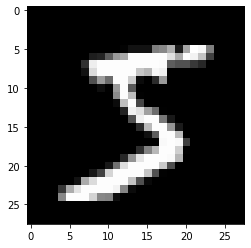

In [6]:
plt.imshow(image[0,0,:,:], 'gray')
plt.show()

# 각 Layer별 설명
- Network 쌓기 위한 준비

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


## Convolution¶
 
- in_channels: 받게 될 channel의 갯수
- out_channels: 보내고 싶은 channel의 갯수
- kernel_size: 만들고 싶은 kernel(weights)의 사이즈

In [8]:
nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5,
stride=1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [9]:
layer = nn.Conv2d(1,20,5,1).to(torch.device('cpu'))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

- weight 확인 & 시각화

In [10]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

- 여기서 weight는 학습 가능한 상태이기 때문에 바로 numpy로 뽑아낼 수 없음
- detach() method는 그래프에서 잠깐 빼서 gradient에 영향을 받지 않게 함

In [11]:
"weight = weight.numpy() - detach 이전 error"
weight = weight.detach().numpy()

In [12]:
weight.shape

(20, 1, 5, 5)

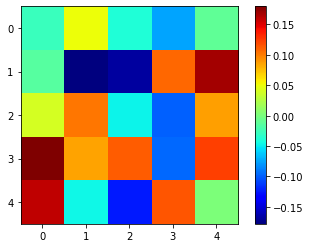

In [13]:
plt.imshow(weight[0,0,:,:], 'jet')
plt.colorbar()
plt.show()

- output 시각화 준비를 위해 numpy화

In [14]:
output_data = layer(image)

In [15]:
output = output_data.cpu().detach().numpy()

In [16]:
output.shape

(1, 20, 24, 24)

- Input으로 들어간 이미지 numy화

In [17]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

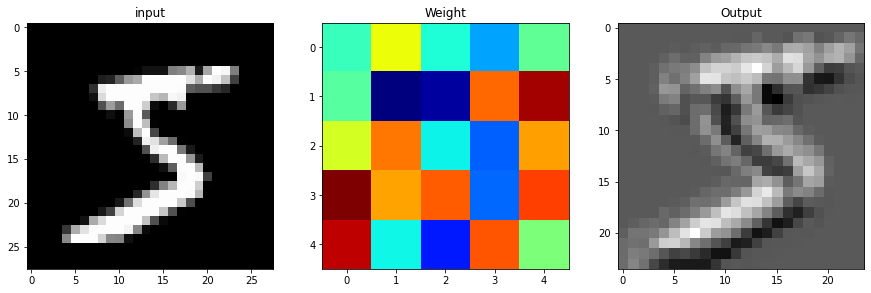

In [18]:
plt.figure(figsize=(15,30))
plt.subplot(131)
plt.title('input')
plt.imshow(np.squeeze(image_arr), 'gray')

plt.subplot(132)
plt.title('Weight')
plt.imshow(weight[0,0,:,:], 'jet')

plt.subplot(133)
plt.title('Output')
plt.imshow(output[0,0,:,:], 'gray')

plt.show()

# convolution layer의 가중치를 input이 조정받은 것이 output

## Pooling

In [19]:
image.shape

torch.Size([1, 1, 28, 28])

In [20]:
pool = F.max_pool2d(image, 2, 2)
pool.shape

torch.Size([1, 1, 14, 14])

In [21]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [22]:
image_arr.shape

(1, 1, 28, 28)

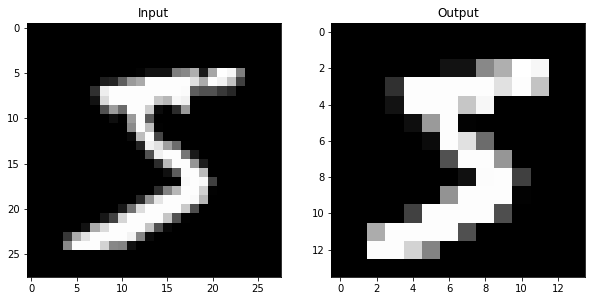

In [23]:
plt.figure(figsize=(10,15))

plt.subplot(121)
plt.title("Input")
plt.imshow(np.squeeze(image_arr), 'gray')

plt.subplot(122)
plt.title("Output")
plt.imshow(np.squeeze(pool_arr), 'gray')

plt.show()

## Linear
nn.Linear는 2d가 아닌 1d만 들어가기 때문에 .view() 1D로 펼쳐줘야함

In [24]:
flatten = image.view(1,28*28) # (batch_size, flatten_size)
flatten.shape

torch.Size([1, 784])

In [25]:
lin = nn.Linear(784, 10)(flatten)
lin.shape

torch.Size([1, 10])

In [26]:
lin

tensor([[-0.0482,  0.0689, -0.3847, -0.1623,  0.0530,  0.1663,  0.2878, -0.1231,
          0.2232,  0.3749]], grad_fn=<AddmmBackward0>)

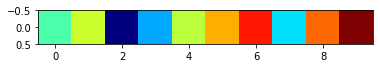

In [27]:
plt.imshow(lin.detach().numpy(), 'jet')
plt.show()

## Softmax

In [28]:
with torch.no_grad():
    flatten = image.view(1, 28*28)
    lin = nn.Linear(784, 10)(flatten)
    softmax = F.softmax(lin, dim=1)

In [29]:
softmax

tensor([[0.0997, 0.0700, 0.0951, 0.1275, 0.1037, 0.0980, 0.1016, 0.1045, 0.0834,
         0.1164]])

In [30]:
np.sum(softmax.numpy())

1.0

nn 과 nn.functional의 차이점

- nn은 학습 파라미터가 담긴 것
- nn.functional은 학습 파라미터가 없는 것이라 생각하면 간단


In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1  = nn.Conv2d(1,20,5,1)
        self.conv2  = nn.Conv2d(20,50,5,1)
        self.fc1    = nn.Linear(4*4*50, 500)
        self.fc2    = nn.Linear(500,10)

    def forward(self, x):
        # Feature Extraction
        x   = F.relu(self.conv1(x))
        x   = F.max_pool2d(x, 2, 2)
        x   = F.relu(self.conv2(x))
        x   = F.max_pool2d(x, 2, 2)

        print(x.shape)      ### flatten 할 때, shape을 알아보기 위해

        # Fully Connected (Classification)
        x   = x.view(-1, 4*4*50)  # (batch_size, flatten_size)
        x   = F.relu(self.fc1(x))
        x   = self.fc2(x)
        return F.log_softmax(x, dim=1)

- Image를 Model에 넣어서 결과 확인

In [32]:
model = Net()

In [33]:
result = model.forward(image)

torch.Size([1, 50, 4, 4])


In [34]:
result

tensor([[-2.3652, -2.2454, -2.2392, -2.2400, -2.3565, -2.3336, -2.3532, -2.3265,
         -2.2754, -2.3023]], grad_fn=<LogSoftmaxBackward0>)

In [35]:
image.shape

torch.Size([1, 1, 28, 28])

In [36]:
model.conv1(image).shape

torch.Size([1, 20, 24, 24])